In [1]:
import os
import numpy as np
import pandas as pd
import keras
import shutil

import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization
from keras.layers import Activation, ZeroPadding2D, Add, Concatenate

from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import keras.backend as K

Using TensorFlow backend.


In [2]:
image_path = 'celeba-dataset/img_align_celeba'
attributes_path = 'celeba-dataset/list_attr_celeba.csv'
image_folder = 'categories'

### Load attribute data:

In [3]:
attributes_df = pd.read_csv(attributes_path)
attributes_df.columns.values

FileNotFoundError: File b'celeba-dataset/list_attr_celeba.csv' does not exist

In [4]:
attributes_to_keep = ['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Brown_Hair',
       'Bushy_Eyebrows', 'Goatee',
       'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male',
       'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pointy_Nose', 'Smiling', 'Straight_Hair',
       'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Young']
attribute_data = attributes_df[attributes_to_keep]
attribute_data = attribute_data.values[:,1:] # note that index starts with 0 and image id with 1!


### Load image data:



### Define data generators

In [5]:
target_size = (128, 128)
input_shape = (target_size[0], target_size[1], 3)
batch_size = 16

data_generator = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)

train_generator = data_generator.flow_from_directory(image_folder, 
                                                     target_size=target_size, 
                                                     batch_size=batch_size)


Found 202599 images belonging to 202599 classes.


In [15]:
x, y = train_generator.next()
y = np.argmax(y, axis = 1)

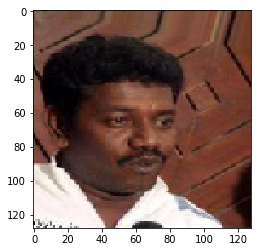

In [16]:
plt.imshow(x[10])

## Define networks:


### Parameters

In [ ]:
latent_dim = 128
epochs = 10
save_interval = 1
batches_per_epoch = train_generator.n // batch_size

In [31]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true*y_pred)

### Create Generator

In [6]:


m1 = generator_input_model(100,5)
model_list = [m1]
m1.output_shape[1:]

m2 = generator_conv_block(m1.output_shape[1:])
model_list.append(m2)

# new_model 
model = generator_conv_block(model_list[-1].output_shape[1:])
model_list.append(model)

total_model = Sequential()
for m in model_list:
    total_model.add(m)
#total_model.add(m1)
#total_model.add(m2)
total_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 4, 4, 3)           5088      
_________________________________________________________________
model_2 (Model)              (None, 8, 8, 3)           96        
_________________________________________________________________
model_3 (Model)              (None, 16, 16, 3)         96        
Total params: 5,280
Trainable params: 5,268
Non-trainable params: 12
_________________________________________________________________


In [8]:
dc = discriminator_classifier(5)
d1 = discriminator_conv_block((8,8,3))
d2 = discriminator_conv_block((16,16,3))
d3 = discriminator_conv_block((32,32,3))

d_list = [d1, d2, d3]

In [9]:
in_features = Input(shape=[5])
in_image = Input(shape=[16,16,3])

total_cnn = Sequential()
for i in range(len(d_list)-1,-1,-1):
    total_cnn.add(d_list[i])
    

total_d = Model([in_image, in_features], dc([total_cnn(in_image), in_features]))

In [10]:
total_d.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 16, 16, 3)    0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       multiple             288         input_12[0][0]                   
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 5)            0                                            
__________________________________________________________________________________________________
model_4 (Model)                 (None, 1)            1431        sequential_3[1][0]               
                                                                 input_11[0][0]                   
Total para

In [2]:
def generator_input_model(latent_dim, nbr_input_features):
    generator_input = Input(shape=[latent_dim + nbr_input_features])
    fc = Dense(4*4*3)(generator_input)
    fc = LeakyReLU(alpha=0.2)(fc)
    image = Reshape((4, 4, 3))(fc)
    return Model(generator_input, image)

def generator_conv_block(input_shape):
    image_input = Input(shape=input_shape)
    image = UpSampling2D()(image_input)
    image = Conv2D(3, kernel_size=3, padding="same")(image)
    image = BatchNormalization()(image)
    image = LeakyReLU(alpha=0.2)(image)
    return Model(image_input, image)

def discriminator_classifier(nbr_input_features):
    fc_size = (4*4*3 + nbr_input_features )// 2
    image_input = Input(shape=(4,4,3))
    image_flat = Flatten()(image_input)
    
    feature_input = Input(shape=[nbr_input_features])
    classifier_input = Concatenate()([image_flat, feature_input])
    
    hidden = Dense(fc_size)(classifier_input)
    hidden = LeakyReLU(alpha=0.2)(hidden)
    out = Dense(1, activation='sigmoid')(hidden)
    
    return Model([image_input, feature_input], out)

def discriminator_conv_block(input_shape):
    image_input = Input(shape=input_shape)
    image = Conv2D(3, kernel_size=3, padding="same", strides=2)(image_input)
    image = BatchNormalization()(image)
    image = LeakyReLU(alpha=0.2)(image)
    return Model(image_input, image)
    

def build_discriminator():

    model = Sequential()

    model.add(Conv2D(32, kernel_size=5, strides=2, input_shape=input_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=5, strides=2, padding="same"))
    #model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=5, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    #model.summary()

    img = Input(shape=input_shape)
    validity = model(img)

    return Model(img, validity)

### Generate models!

In [3]:
noise_size = 100
nbr_of_features = 5
in_features = Input(shape=[nbr_of_features])

def next_generator_model(previous_model):
    new_block = generator_conv_block(previous_model.output_shape[1:])
    new_model = Sequential()
    new_model.add(previous_model)
    new_model.add(new_block)
    return new_model

def next_discriminator_cnn(previous_cnn_network):
    previous_image_size = previous_cnn_network.input_shape[1]
    input_shape = (previous_image_size*2, previous_image_size*2, 3)
    new_block = discriminator_conv_block(input_shape)
    new_cnn_model = Sequential()
    new_cnn_model.add(new_block)
    new_cnn_model.add(previous_cnn_network)
    return new_cnn_model


## Step 1

In [4]:

# First generator step
current_generator_model = generator_input_model(noise_size, nbr_of_features)


# First Discriminator step, only classifier
#total_d = Model([in_image, in_features], d1([total_cnn(in_image), in_features]))
d_c = discriminator_classifier(nbr_of_features)

#d_1 = Model([in_image, in_features], dc([in_image, in_features]))


# Step 2

In [5]:
# Second step generator

previous_generator_model = current_generator_model
current_generator_model = next_generator_model(previous_generator_model)
                                               
in_image = Input(shape=current_generator_model.output_shape[1:])
                                               
current_discriminator_cnn = discriminator_conv_block((8, 8, 3))
discriminator = Model([in_image, in_features], d_c([current_discriminator_cnn(in_image), in_features]))

#discriminator.summary()
#current_generator_model.summary()

                                            

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 8, 8, 3)      0                                            
__________________________________________________________________________________________________
model_4 (Model)                 (None, 4, 4, 3)      96          input_6[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1)            1431        model_4[1][0]                    
                                                                 input_1[0][0]                    
Total para

## Step 3,...,6

In [12]:




# Generator step    
previous_generator_model = current_generator_model
current_generator_model = next_generator_model(previous_generator_model)
#current_generator_model.summary()
previous_generator_model.trainable=False
#current_model.summary()
in_image = Input(shape=current_generator_model.output_shape[1:])
previous_discriminator_cnn = current_discriminator_cnn
current_discriminator_cnn = next_discriminator_cnn(previous_discriminator_cnn)
discriminator = Model([in_image, in_features], d_c([current_discriminator_cnn(in_image), in_features]))


In [14]:
previous_discriminator_cnn.trainable = False
d_c.trainable = False

In [ ]:
optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=optimizer,
                      metrics=['accuracy'])

# Build the generator
generator = build_generator()

# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)



In [ ]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,:])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/celebA_%d.png" % epoch)
    plt.close()

### Train!

In [42]:

d_loss_hist = list()
g_loss_hist = list()
for epoch in range(epochs):

    # ---------------------
    #  Train Discriminator
    # ---------------------
    for i_batch in range(batches_per_epoch):
    # Select a random batch of images
        imgs, y = train_generator.next()
        b_size = imgs.shape[0]
        valid = np.ones((b_size, 1))
        fake = np.zeros((b_size, 1))
        
        if i_batch%40 == 0:
            print('Currently on batch: %d for epoch: %d' % (i_batch, epoch))

        # Sample noise and generate a batch of new images
        noise = np.random.normal(0, 1, (b_size, latent_dim))
        gen_imgs = generator.predict(noise)

        # Train the discriminator (real classified as ones and generated as zeros)
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        # Train the generator (wants discriminator to mistake images as real)
        g_loss = combined.train_on_batch(noise, valid)
    
    d_loss_hist.append(d_loss[0])
    g_loss_hist.append(g_loss)
    # Plot the progress
    print ("epoch: %d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
    
    # If at save interval => save generated image samples
    if epoch % save_interval == 0:
        save_imgs(epoch)

    

Currently on batch: 0 for epoch: 0


/home/student/anaconda3/envs/dml_gpu/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Currently on batch: 40 for epoch: 0
Currently on batch: 80 for epoch: 0
Currently on batch: 120 for epoch: 0
Currently on batch: 160 for epoch: 0
Currently on batch: 200 for epoch: 0
Currently on batch: 240 for epoch: 0
Currently on batch: 280 for epoch: 0


ValueError: Input arrays should have the same number of samples as target arrays. Found 359 input samples and 512 target samples.

In [113]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 128)               0         
_________________________________________________________________
sequential_26 (Sequential)   (None, 128, 128, 3)       1298371   
Total params: 1,298,371
Trainable params: 1,297,923
Non-trainable params: 448
_________________________________________________________________


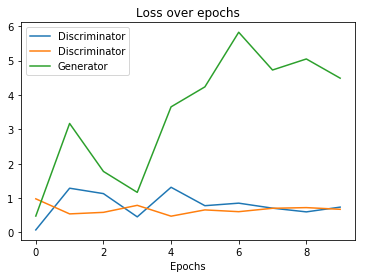

In [37]:
def plot_history(d_loss_hist, g_loss_hist):
    
    plt.figure()
    plt.plot(d_loss_hist, label='Discriminator')
    plt.plot(g_loss_hist, label='Generator')
    plt.xlabel('Epochs')
    plt.legend(loc='best')
    plt.title('Loss over epochs')
    
plot_history(d_loss_hist, g_loss_hist)  